# EE 605 Digital Image Processing
# Assignment 2: Panorama Stitching
#### -Karan Khajanchi (21110096) 
##### (B.Tech'21 Electrical Engineering)<br>
**NOTE:**  In this assignment, all matrix and math operations performed with NumPy. In-built OpenCV functions are used only to detect, extract, and match features. All other operations (RANSAC, homography matrix estimation, warping, and blending) are implemented from scratch.The implementation primarily relies on fundamental mathematics(linear algebra).**The complete pyhton implementation is based on the lecture series on Image Stitching by Prof. Shree K. Nayar of Columbia University, which is available on https://fpcv.cs.columbia.edu/  and also on the YouTube channel- First Principles of Computer Vision.(https://www.youtube.com/playlist?list=PL2zRqk16wsdp8KbDfHKvPYNGF2L-zQASc)**<br>


In [1]:
#importing libraries
import cv2
import numpy as np
import glob
import imutils
import matplotlib.pyplot as plt 

In [2]:
#functions that will extensively be used in this project
#plots the image in using matplotlib
def plot_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

#gives the coordinates of point i,j after transformation through the homography matrix
def get_point(i,j,H):
    point = np.array([i, j, 1])
    transformed = np.dot(H, point)
    transformed /= transformed[2]
    transformed = transformed.astype(np.int32)[:2]
    return np.array(transformed)

First we create a function to detect and match features, and extract keypoints, between two images. This is done using OpenCV ORB(Oriented FAST and Rotated BRIEF) feature detector, since ORB is known for its speed and efficiency. It was designed with real-time performance in mind and is much faster than some traditional feature detectors like SIFT or SURF. 

In [3]:
def detectAndMatch(img1, img2, n = 30):
    #initiating the orb detector, which returns the matching keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1,None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2,None)

    #we use the brute force matcher which helps us to match these matching descriptors through their keypoints
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key = lambda x:x.distance) 

    #extracting the coordinates from the matched result array
    coords = []
    for match in matches:
        coords.append((keypoints1[match.queryIdx].pt, keypoints2[match.trainIdx].pt))
        
    return np.array(coords[:n]).astype(np.int32)

Next, we create a function to compute the Homography between two images. Again this is based on implementation mentioned in the lecture series(see NOTE). It boils down to solving a matrix equation.

In [4]:
def computeHomography(matches):
    #Creating an empty matrix of twice the size of matching coordinates, and columns=9 since the homography matrix 3x3(9 unknowns)
    A = np.zeros((2*len(matches), 9))
    #now we fill this matrix as derived in the lecture series(refer NOTE) using the matched coordinates
    for i, mat in enumerate(matches):
        src = mat[0]
        dst = mat[1]
        x1 = src[0]
        x2 = dst[0]
        y1 = src[1]
        y2 = dst[1]
        A[2*i] = np.array([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
        A[2*i+1] = np.array([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])
    
    A = np.array(A)                     #converting A to a numpy array
    U, S, V = np.linalg.svd(A)          #Solving for the (U)S(Vt) using the singular value decomposition
    H = np.reshape(V[-1], (3, 3))       #converting the Vt matrix into a 3x3 matrix, the homography matrix is obtained  
    # print(H)
    return H

Next, we write the RANSAC algorithm. The RANSAC algorithm is used because Homography estimation often involves matching points between images, and RANSAC can effectively handle cases where a few mismatches or outliers exist by iteratively fitting models to subsets of correspondences, thus producing more reliable homography estimates in the presence of errors.

In [5]:
def RANSAC(matches, trials = 10000, threshold = 10, n = 4):
    #creating variables for various quantities
    bestH = None
    max_inliers = 0
    randomSample = None
    bestSample = None
    #running a loop for the maximum number of trials
    for trialIndex in range(trials):
        inliers = []
        randomSample = matches[np.random.choice(len(matches), size=n, replace=False)] #taking n=4 samples per iteration fromt he matches,without replacemnt and estimating the homography
        H = computeHomography(randomSample)
        for match in matches:                        #for the given homography we calculate the no of inliers
            src = np.append(match[0], 1).T        
            dst = np.append(match[1], 1).T
            transformed = np.dot(H, src)
            transformed /= transformed[2]           #transforming the coordinates and normalizing wrt z coordinate
            if np.linalg.norm(transformed - dst) < threshold: #if the euclidian distance is less than the threshold it is inlier
                inliers.append(match)
        if len(inliers) > max_inliers:           #if the no of inliers in the current iteration is greater than the max inliers found till now, we update the homography with the current one
            bestSample = randomSample
            max_inliers = len(inliers)
            bestH = H

    # print('Maximum inliers found = ', max_inliers)
    return bestH 

Next, we create a function to project an image on a corresponding image using the Homography matrix computed above. The homography matrix defines the relationship between the coordinates of source image plane and destination image plane. The **get_point()** function defined above essentially does this coordinate conversion and gives us the result after normalizing with the 'z' values. 

In [6]:
def projectImage(img2, H, finalImg, offset = [400,400]):
    #calculating the inverse of homography for backward transformation of the image
    Hinv = np.linalg.inv(H)
    r,c,_ = img2.shape #gives the no. of rows and columns of the input image

    #First we need to calculate the bounded box of the final warped image. For this we apply forward transformation of all 4 corners of the input image and the bounded box, through homography.
    topLeft = get_point(0, 0, H) 
    topRight = get_point(0, c-1, H) 
    bottomLeft = get_point(r-1, 0, H) 
    bottomRight = get_point(r-1, c-1, H)

    #we need to get the min and max values of x and y coordinates of the bounding box
    box = np.array([topLeft, topRight, bottomLeft, bottomRight])
    minX = np.min(box[:, 0])
    maxX = np.max(box[:, 0])
    minY = np.min(box[:, 1])
    maxY = np.max(box[:, 1])

    #once we have the min and max, x and y coordinates, we create a box using the range, we will apply backward transformation on this box
    pts = np.indices((maxX - minX, maxY - minY)).reshape(2, -1)
    pts = np.vstack((pts, np.ones(pts.shape[1]))).astype(np.int32)
    yo, xo = pts[1, :], pts[0, :]
    pts[0, :] += minX
    pts[1, :] += minY

    #Apply the backward transformation on the newly created box using the inverse homography matrix to get the transformed coordinates
    transformedPoints = np.dot(Hinv, pts)
    xt = np.divide(np.array(transformedPoints[0, :]),np.array(transformedPoints[2, :])).astype(np.int32)
    yt = np.divide(np.array(transformedPoints[1, :]),np.array(transformedPoints[2, :])).astype(np.int32)

    #these transformed coordinates belong on the original image, hence we apply a check to remove negative values of xt,yt and values out of bound
    indices = np.where((yt >= 0) & (yt < c) & (xt >= 0) & (xt < r))
    xt = xt[indices]
    yt = yt[indices]
    xo = xo[indices]
    yo = yo[indices]

    
    warpedImage = np.zeros((maxX - minX, maxY - minY, 3))            #creating a new image with zeros
    warpedImage[xo-minX,yo-minY] = img2[xt,yt]                       #creating the warped image using the values of transformed coordinates
    finalImg[xo+offset[0],yo+offset[1]] = img2[xt,yt]                #placing the warped image on the final image using the transformed coordinates
    #offset is used to adapt to the padding done in the main image and changing coordinates
    
    #converting to 8 bit intergers, the allowed values of the intensity levels
    warpedImage = warpedImage.astype(np.uint8)
    finalImg = finalImg.astype(np.uint8)
    
    return warpedImage, finalImg

Finally, we create the function to combine all the tasks that we wish to perform. We will call this function to perform the stitching. It takes the two images and any previous Homography matrix, otherwise the identity matrix, as inputs and gives that latest homography, the warped image after transformation and the final image after stitching, as its output.

In [7]:
def stitch(img1, img2, prevH, finalImg,offset = [400,400]):
    matches = detectAndMatch(img1, img2)           #detect features
    H = RANSAC(matches)                            #estimate homography using RANSAC
    prevH = np.dot(prevH, H)                       #get the new homography
    warpedImage,finalImg = projectImage(img2, prevH, finalImg, offset=offset)   #get the warped image 
    return warpedImage, prevH, finalImg

Perform the stitching.

My implementation


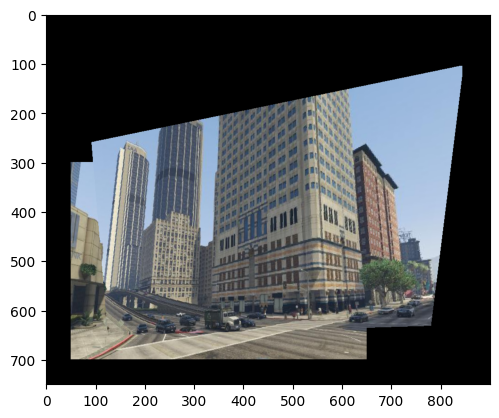

OpenCV implementation


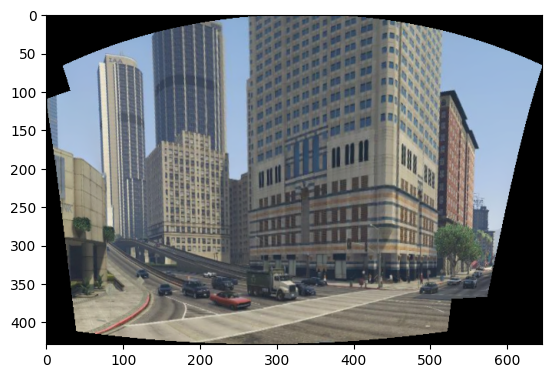

In [12]:
#We execute the stitching operation on the image set4
image_paths4 = glob.glob('scene4/*.jpg')
images4 = []
shape = [600,400]
for image in image_paths4:
    img = cv2.imread(image)
    img = cv2.resize(img,shape)
    images4.append(img)

offset4 = [300,50]
prevH4 = np.eye(3)
finalImg4 =  cv2.copyMakeBorder(images4[0], 300, 50, 50, 250, cv2.BORDER_CONSTANT, value=(0, 0, 0))
_, _, finalImg4 = stitch(images4[0], images4[1],prevH4,finalImg4,offset4)
print("My implementation")
plot_image(finalImg4)
imageStitcher = cv2.Stitcher_create()
error, stitched_image4 = imageStitcher.stitch(images4)
print("OpenCV implementation")
plot_image(stitched_image4)

My implementation


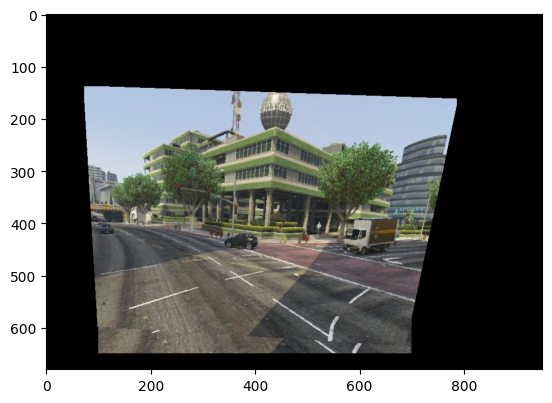

OpenCV implementation


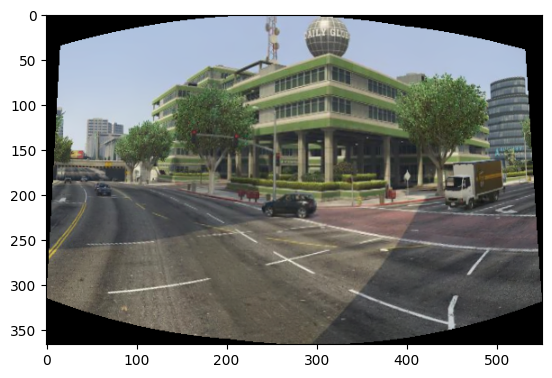

In [13]:
#We execute the stitching operation on the image set5
image_paths5 = glob.glob('scene5/*.jpg')
images5 = []
shape = [600,400]
for image in image_paths5:
    img = cv2.imread(image)
    img = cv2.resize(img,shape)
    images5.append(img)

offset5 = [250,100]
prevH5 = np.eye(3)
finalImg5 =  cv2.copyMakeBorder(images5[1], 250, 30, 100, 250, cv2.BORDER_CONSTANT, value=(0, 0, 0))
_, _, finalImg5 = stitch(images5[1], images5[0],prevH5,finalImg5,offset5)
print("My implementation")
plot_image(finalImg5)
imageStitcher = cv2.Stitcher_create()
error, stitched_image5 = imageStitcher.stitch(images5)
print("OpenCV implementation")
plot_image(stitched_image5)

My implementation


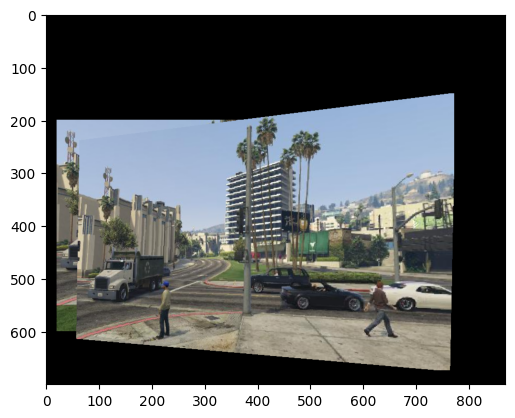

OpenCV implementation


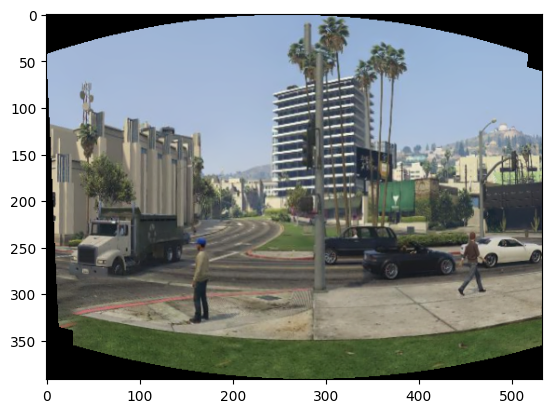

In [14]:
#We execute the stitching operation on the image set6
image_paths6 = glob.glob('scene6/*.jpg')
images6 = []
shape = [600,400]
for image in image_paths6:
    img = cv2.imread(image)
    img = cv2.resize(img,shape)
    images6.append(img)

offset6 = [200,20]
prevH6 = np.eye(3)
finalImg6 =  cv2.copyMakeBorder(images6[1], 200, 100, 20, 250, cv2.BORDER_CONSTANT, value=(0, 0, 0))
_, _, finalImg6 = stitch(images6[1], images6[0],prevH6,finalImg6,offset6)
print("My implementation")
plot_image(finalImg6)
imageStitcher = cv2.Stitcher_create()
error, stitched_image6 = imageStitcher.stitch(images6)
print("OpenCV implementation")
plot_image(stitched_image6)

In [16]:
cv2.imwrite("myresult4.png",finalImg4)
cv2.imwrite("myresult5.png",finalImg5)
cv2.imwrite("myresult6.png",finalImg6)
cv2.imwrite("opencv4.png",stitched_image4)
cv2.imwrite("opencv5.png",stitched_image5)
cv2.imwrite("opencv6.png",stitched_image6)

True

### Conclusion:
- In conclusion, this assignment has successfully demonstrated the ability to stitch multiple images together to create a panoramic view. The utilization of feature detection and matching techniques, along with geometric transformations(warping using homography), has allowed us to merge images with varying perspectives into a cohesive panorama.
- The robustness and accuracy may depend on the type of feature detectors used. The accuracy of the stitching process has been enhanced through techniques like RANSAC, ensuring that the final panorama aligns well with minimal distortion.
- While we've achieved a robust panorama stitching system, there is room for further enhancements. Future work could involve optimizing the code further for large-scale panoramas, exploring advanced blending techniques for smoother transitions. 